# **Ujian Akhir Semester - Pengolahan Bahasa Alami**

## Anggota Kelompok:
- **Kevin Philips Tanamas** (220711789)  
- **Richard Angelico** (220711747)
- **Anthony Alvin Nathaniel** (220711773)
- **Nicholas Raymond Thosimaru** (220712111)
- **Maria** (220711969)

## Library Import

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import gc
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from seqeval.scheme import BILOU
from seqeval.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, TimeDistributed, Dropout
from collections import Counter
from sklearn.model_selection import train_test_split

tqdm.pandas()

2025-06-29 20:46:35.006644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 20:46:35.291284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751204795.353310 2181985 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751204795.367677 2181985 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751204795.468480 2181985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Loading Function

## Load Data

In [2]:
def insert_blank_lines(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8') as outfile:
        for line in infile:
            outfile.write(line)
            if line.strip().endswith(('.-O', '!-O', '?-O')):
                outfile.write('\n') 

insert_blank_lines("dataset_betawi.txt", "dataset_betawi_split.txt")

In [3]:
def load_data(file_path):
    sentences = []
    labels = []
    sentence = []
    label_seq = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                # Baris kosong = akhir kalimat
                if sentence:
                    sentences.append(sentence)
                    labels.append(label_seq)
                    sentence = []
                    label_seq = []
                continue

            # Hapus nomor dan titik dua di depan (contoh: "12: Ane-O")
            if ":" in line:
                line = line.split(":", 1)[1].strip()

            if "-" not in line:
                continue

            token, tag = line.rsplit("-", 1)
            sentence.append(token)
            label_seq.append(tag)

        # Tambahkan kalimat terakhir jika ada
        if sentence:
            sentences.append(sentence)
            labels.append(label_seq)

    return sentences, labels

In [4]:
with open("./dataset_betawi_split.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

for i, line in enumerate(lines[:20]):
    print(f"{i+1}: {line.strip()}")


1: Ane-O
2: pake-O
3: Honda-B-PRODUCT
4: Jazz-I-PRODUCT
5: GK5-I-PRODUCT
6: 2014-L-PRODUCT
7: (-O
8: pertama-O
9: diluncurkan-O
10: )-O
11: .-O
12: 
13: Mobilnya-B-OTHERS_POSITIVE
14: bagus-I-OTHERS_POSITIVE
15: dan-I-OTHERS_POSITIVE
16: bagus-I-OTHERS_POSITIVE
17: sesuai-I-OTHERS_POSITIVE
18: motto-I-OTHERS_POSITIVE
19: ,-I-OTHERS_POSITIVE
20: asik-I-OTHERS_POSITIVE


In [5]:
# Load all data
full_file = "./dataset_betawi_split.txt"
sentences, labels = load_data(full_file)

# Check if data loaded
print(f"Loaded {len(sentences)} samples.")

# Split into train (70%) and temp (30%)
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)

# Split temp into validation (15%) and test (15%)
valid_sentences, test_sentences, valid_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.5, random_state=42
)

# Create dataframes
train_df = pd.DataFrame({'tokens': train_sentences, 'tags': train_labels})
valid_df = pd.DataFrame({'tokens': valid_sentences, 'tags': valid_labels})
test_df = pd.DataFrame({'tokens': test_sentences, 'tags': test_labels})
df_all = pd.DataFrame({'tokens': sentences, 'tags': labels})

# Informasi tentang kolom
print("\nInformasi kolom DataFrame:")
print(df_all.dtypes)

# Deskripsi singkat isi data
lengths = [len(s) for s in sentences]
print("\nDeskripsi data:")
print(f"Total kalimat: {len(sentences)}")
print(f"Rata-rata panjang kalimat: {sum(lengths)/len(lengths):.2f} tokens")
print(f"Kalimat terpendek: {min(lengths)} tokens")
print(f"Kalimat terpanjang: {max(lengths)} tokens")

# Print sizes
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Loaded 867 samples.

Informasi kolom DataFrame:
tokens    object
tags      object
dtype: object

Deskripsi data:
Total kalimat: 867
Rata-rata panjang kalimat: 18.45 tokens
Kalimat terpendek: 1 tokens
Kalimat terpanjang: 124 tokens
Train: 606, Valid: 130, Test: 131


In [6]:
def validate_data(sentences, labels):
    for i, (sent, lbls) in enumerate(zip(sentences, labels)):
        if len(sent) != len(lbls):
            print(f"Mismatch in sentence {i}: {len(sent)} tokens, {len(lbls)} tags")
        for tag in lbls:
            if tag != 'O' and '-' not in tag:
                print(f"Invalid tag in sentence {i}: {tag}")
            if tag != 'O' and not any(prefix in tag for prefix in ['B-', 'I-', 'L-', 'U-']):
                print(f"Non-BILOU tag in sentence {i}: {tag}")

# Validate dataset after loading
print("Validating dataset...")
validate_data(sentences, labels)
print("Validation complete.")

Validating dataset...
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OT

## Data Checking (Liat Semua Tags) & Visualization

In [7]:
# Set all tags (flattened) from training labels
all_tags_flat = [tag for seq in train_labels for tag in seq]

print(f"Total tags in training: {len(all_tags_flat)}")

print("Tag distribution in training set:")
tag_counts = pd.Series(all_tags_flat).value_counts()
print(tag_counts.head(10))

Total tags in training: 11221
Tag distribution in training set:
O                   6845
PRODUCT             1093
OTHERS_POSITIVE      697
MACHINE_POSITIVE     471
PART_POSITIVE        441
PART_NEGATIVE        310
FUEL_POSITIVE        306
PRICE_POSITIVE       227
SERVICE_POSITIVE     214
SERVICE_NEGATIVE     193
Name: count, dtype: int64


/tmp/ipykernel_2181985/2071062896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")


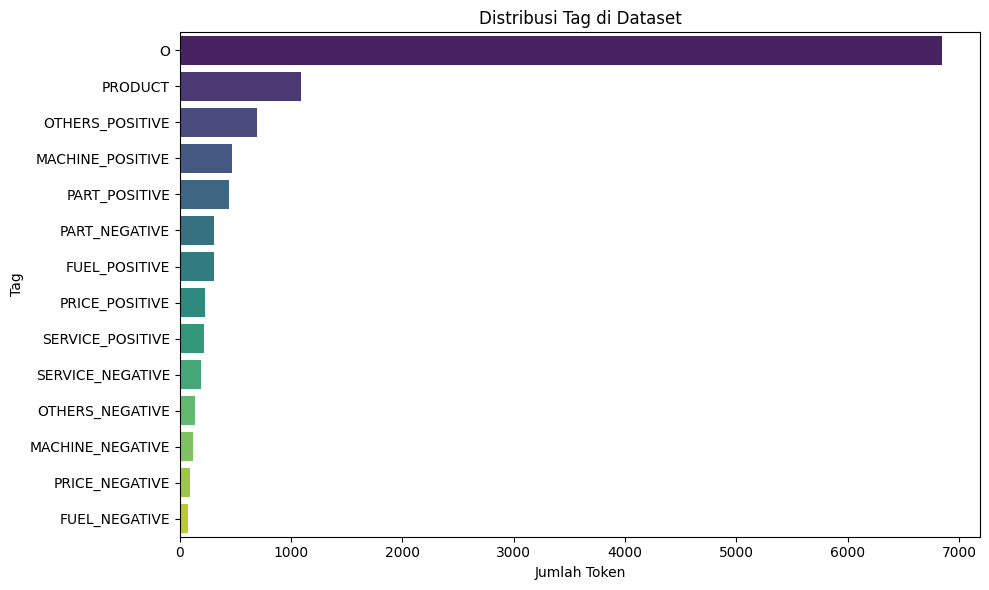

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")
plt.title("Distribusi Tag di Dataset")
plt.xlabel("Jumlah Token")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

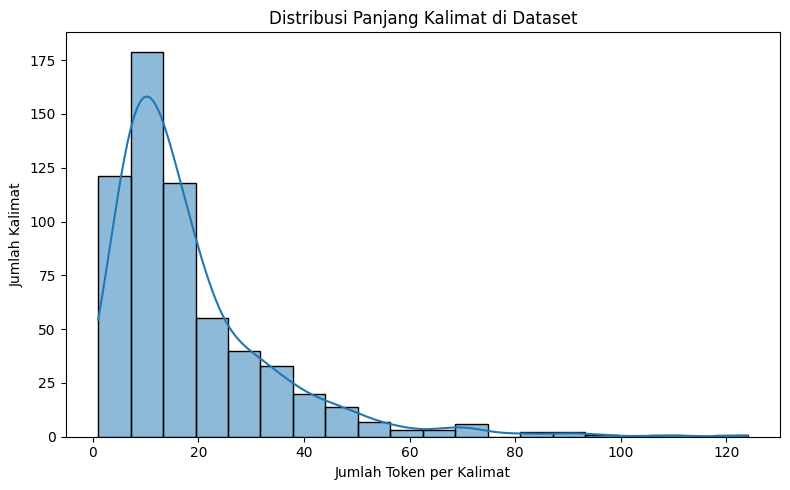

In [9]:
train_lengths = [len(seq) for seq in train_sentences]

plt.figure(figsize=(8, 5))
sns.histplot(train_lengths, bins=20, kde=True)
plt.title("Distribusi Panjang Kalimat di Dataset")
plt.xlabel("Jumlah Token per Kalimat")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2181985/2212785168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")


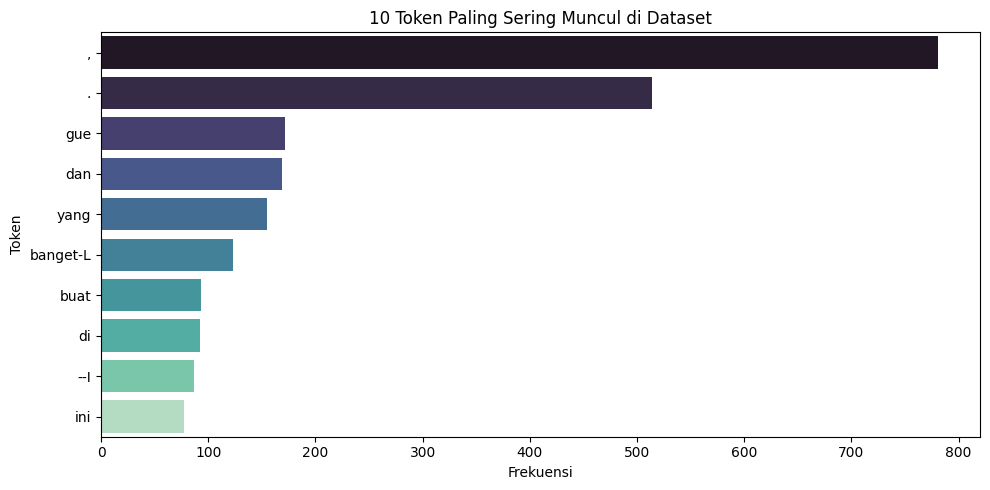

In [10]:
all_tokens = [tok for seq in train_sentences for tok in seq]
token_counts = Counter(all_tokens)
common_tokens = pd.Series(dict(token_counts.most_common(10)))

plt.figure(figsize=(10, 5))
sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")
plt.title("10 Token Paling Sering Muncul di Dataset")
plt.xlabel("Frekuensi")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


/tmp/ipykernel_2181985/1962913272.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")


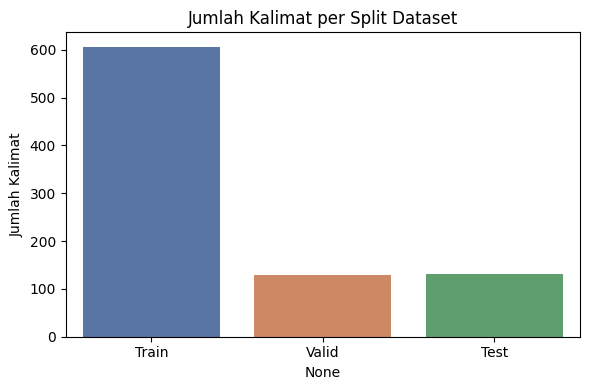

In [11]:
split_counts = pd.Series({
    "Train": len(train_df),
    "Valid": len(valid_df),
    "Test": len(test_df)
})

plt.figure(figsize=(6, 4))
sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")
plt.title("Jumlah Kalimat per Split Dataset")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

## Load FastText Model

In [12]:
# Cek dan unduh FastText model jika belum tersedia
if not os.path.exists('./cc.id.300.bin'):
    print("FastText model not found. Downloading model (this may take a while)...")
    os.system("wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz")
    os.system("gunzip cc.id.300.bin.gz")
    print("Download complete.")

# Load FastText model
# Download file .bin https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
# Extract file .gz
# Pastikan file cc.id.300.bin ada di direktori yang sama dengan Jupyter Notebook ini
print("Loading FastText model...")
ft = fasttext.load_model('./cc.id.300.bin')
print("FastText model loaded successfully.")

# Set embedding size dan panjang maksimum urutan
emb_size = 300
max_seq_len = 128


Loading FastText model...
FastText model loaded successfully.


## Tag Mapping

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Buat mapping tag ke ID
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0
index2tag = {idx: tag for tag, idx in tag2index.items()}

num_tags = len(tag2index)

# Fungsi untuk encoding dan padding label
def encode_tags(tags, tag2index, max_len):
    tag_ids = [tag2index.get(tag, tag2index['PAD']) for tag in tags]
    return pad_sequences([tag_ids], maxlen=max_len, padding='post', value=tag2index['PAD'])[0]

train_df['tag_ids'] = train_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
valid_df['tag_ids'] = valid_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
test_df['tag_ids'] = test_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))

print(f"Number of unique tags (including PAD): {num_tags}")

Number of unique tags (including PAD): 15


## Word Embeddings Function

In [14]:
# Membuat fungsi untuk menghasilkan word embeddings dari token
def get_tok_emb(tokens):
    emb = np.zeros((max_seq_len, emb_size))
    for i, word in enumerate(tokens[:max_seq_len]):
        emb[i] = ft.get_word_vector(word)
    return emb

# Proses pembuatan embeddings untuk setiap token dalam dataset
print("Creating word embeddings...")
train_df['tokens_embedding'] = train_df['tokens'].progress_apply(get_tok_emb)
valid_df['tokens_embedding'] = valid_df['tokens'].progress_apply(get_tok_emb)
test_df['tokens_embedding'] = test_df['tokens'].progress_apply(get_tok_emb)

Creating word embeddings...


100%|██████████| 131/131 [00:00<00:00, 2091.70it/s]


In [15]:
# Membuat mapping untuk tag ke indeks dan sebaliknya
print("Creating tag mapping...")

# Ambil semua tag unik dari data latih
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
print(f"Number of unique tags: {len(all_tags)}")

# Buat mapping dari tag ke indeks, dengan indeks 0 untuk padding
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0  # PAD token at index 0

# Buat mapping sebaliknya dari indeks ke tag
index2tag = {idx: tag for tag, idx in tag2index.items()}

# Tampilkan beberapa mapping untuk verifikasi
print("Tag to index mapping (sample):")
for i, (tag, idx) in enumerate(tag2index.items()):
    if i < 10:  # Tampilkan 10 pertama
        print(f"{tag} -> {idx}")


Creating tag mapping...
Number of unique tags: 14
Tag to index mapping (sample):
FUEL_NEGATIVE -> 1
FUEL_POSITIVE -> 2
MACHINE_NEGATIVE -> 3
MACHINE_POSITIVE -> 4
O -> 5
OTHERS_NEGATIVE -> 6
OTHERS_POSITIVE -> 7
PART_NEGATIVE -> 8
PART_POSITIVE -> 9
PRICE_NEGATIVE -> 10


## Dimensionality Reduction (PCA)

In [16]:
# Gabungkan semua embedding untuk fit PCA
all_embeddings = np.vstack(train_df['tokens_embedding'].values)
pca_components = 50
pca = PCA(n_components=pca_components)
pca.fit(all_embeddings)

# Transform setiap embedding sequence
def reduce_dims(emb_matrix):
    return pca.transform(emb_matrix)

train_df['tokens_embedding_pca'] = train_df['tokens_embedding'].progress_apply(reduce_dims)
valid_df['tokens_embedding_pca'] = valid_df['tokens_embedding'].progress_apply(reduce_dims)
test_df['tokens_embedding_pca'] = test_df['tokens_embedding'].progress_apply(reduce_dims)

# Update embedding size ke dimensi baru
emb_size = pca_components

100%|██████████| 131/131 [00:00<00:00, 1892.19it/s]


## Optimasi Dataset

In [17]:
X_train = np.stack(train_df['tokens_embedding_pca'].values)
y_train = np.stack(train_df['tag_ids'].values)

X_valid = np.stack(valid_df['tokens_embedding_pca'].values)
y_valid = np.stack(valid_df['tag_ids'].values)

X_test = np.stack(test_df['tokens_embedding_pca'].values)
y_test = np.stack(test_df['tag_ids'].values)

# Expand label dims: (batch_size, timesteps, 1)
y_train = np.expand_dims(y_train, -1)
y_valid = np.expand_dims(y_valid, -1)
y_test = np.expand_dims(y_test, -1)

print("Feature engineering complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")

Feature engineering complete.
X_train shape: (606, 128, 50)
y_train shape: (606, 128, 1)
X_valid shape: (130, 128, 50)
X_test shape: (131, 128, 50)


## Bilstm Model Function

In [18]:
def bilstm_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    Bidirectional LSTM model for NER - highest accuracy but slowest training

    Args:
        max_len_seq: Maximum sequence length
        emb_size: Embedding size
        rnn_units: Number of LSTM units per direction
        num_tags: Number of output tags
        lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')

    # Projection layer to reduce dimensions
    x = Dense(128, activation='relu')(inputs)

    # Bidirectional LSTM - processes sequences in both directions
    # Higher accuracy for context-dependent tasks like NER
    x = Bidirectional(
        LSTM(
            rnn_units,
            return_sequences=True,
            recurrent_dropout=0.0,
            implementation=2  # potentially faster but less stable
        )
    )(x)

    # Dropout for regularization
    x = Dropout(0.3)(x)

    # Output layer
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def bigru_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    Bidirectional GRU model - good balance between speed and accuracy

    Args:
        max_len_seq: Maximum sequence length
        emb_size: Embedding size
        rnn_units: Number of GRU units per direction
        num_tags: Number of output tags
        lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')

    # Projection layer
    x = Dense(128, activation='relu')(inputs)

    # Bidirectional GRU - faster than LSTM with similar capabilities
    x = Bidirectional(
        GRU(
            rnn_units,
            return_sequences=True,
            recurrent_dropout=0.0,
            reset_after=True  # modern GRU implementation
        )
    )(x)

    # Dropout for regularization
    x = Dropout(0.2)(x)

    # Output layer
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [19]:
# Force CPU usage for memory-intensive operations
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU for data preparation

def simple_rnn_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    SimpleRNN model for NER - fastest training, but typically lower accuracy

    Args:
        max_len_seq: Maximum sequence length
        emb_size: Embedding size
        rnn_units: Number of RNN units
        num_tags: Number of output tags
        lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')

    # Optional projection to reduce dimensions
    x = Dense(128, activation='relu')(inputs)

    # SimpleRNN layer - fastest but less capable for sequence modeling
    x = tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True)(x)

    # Dropout for regularization
    x = Dropout(0.2)(x)

    # Output layer with softmax activation for tag prediction
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [20]:
def create_optimized_dataset(X, y, batch_size=16, shuffle=False, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset



## Model Configuration – Arsitektur BilSTM (Bisa dipilih sesuai kebutuhan)

In [21]:
# Buat dataset untuk training dan validasi
batch_size = 16
train_dataset = create_optimized_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataset = create_optimized_dataset(X_valid, y_valid, batch_size=batch_size)

# Konfigurasi callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-4)
]

def get_model(selected_model, max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    if selected_model == 'BiLSTM':
        return bilstm_model(max_len_seq, emb_size, rnn_units, num_tags, lr)
    elif selected_model == 'BiGRU':
        return bigru_model(max_len_seq, emb_size, rnn_units, num_tags, lr)
    elif selected_model == 'SimpleRNN':
        return simple_rnn_model(max_len_seq, emb_size, rnn_units, num_tags, lr)
    else:
        raise ValueError("Model tidak dikenali. Pilih dari: 'BiLSTM', 'BiGRU', 'SimpleRNN'")

# Pilihan model yang tersedia
selected_model = 'BiLSTM'  # Bisa diganti menjadi 'BiGRU' atau 'SimpleRNN'

# Dapatkan model berdasarkan pilihan
model = get_model(
    selected_model=selected_model,
    max_len_seq=X_train.shape[1],
    emb_size=X_train.shape[2],
    rnn_units=64,
    num_tags=num_tags,
    lr=0.001
)

# Tampilkan ringkasan model
model.summary()

W0000 00:00:1751204871.067049 2181985 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 128)       │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 15)        │         1,935 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,279 (419.06 KB)

 Trainable params: 107,279 (419.06 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model dengan EarlyStopping

In [22]:
# Training model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.8031 - loss: 1.9345 - val_accuracy: 0.9074 - val_loss: 0.3555 - learning_rate: 0.0010
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9263 - loss: 0.3040 - val_accuracy: 0.9428 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9429 - loss: 0.2225 - val_accuracy: 0.9433 - val_loss: 0.2048 - learning_rate: 0.0010


## Simpan Metrics Training ke DataFrame

In [23]:
import pandas as pd

# Simpan history training ke CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv(f"history_{selected_model}.csv", index=False)

## Visualisasi Loss dan Accuracy

Shapes before training: (606, 128, 300) (606, 128) (130, 128, 300) (130, 128)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 128, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 128, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 128, 14)        │         1,806 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,150 (543.55 KB)

 Trainable params: 139,150 (543.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7742 - loss: 2.3942

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.7802 - loss: 2.3688 - val_accuracy: 0.9433 - val_loss: 0.4391
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9475 - loss: 0.3945

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9473 - loss: 0.3950 - val_accuracy: 0.9433 - val_loss: 0.3427
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9474 - loss: 0.3096

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9472 - loss: 0.3103 - val_accuracy: 0.9433 - val_loss: 0.3097
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9462 - loss: 0.2825

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9461 - loss: 0.2829 - val_accuracy: 0.9433 - val_loss: 0.2712
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9430 - loss: 0.2575

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.9430 - loss: 0.2571 - val_accuracy: 0.9433 - val_loss: 0.2304
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9429 - loss: 0.2267

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9430 - loss: 0.2263 - val_accuracy: 0.9433 - val_loss: 0.2119
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9456 - loss: 0.2002

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9455 - loss: 0.2003 - val_accuracy: 0.9433 - val_loss: 0.1951
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9431 - loss: 0.1920

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9432 - loss: 0.1916 - val_accuracy: 0.9435 - val_loss: 0.1779
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9446 - loss: 0.1778

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9447 - loss: 0.1774 - val_accuracy: 0.9459 - val_loss: 0.1636
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9472 - loss: 0.1664

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9474 - loss: 0.1660 - val_accuracy: 0.9505 - val_loss: 0.1535
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9520 - loss: 0.1538

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9521 - loss: 0.1536 - val_accuracy: 0.9538 - val_loss: 0.1460
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9559 - loss: 0.1420

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9559 - loss: 0.1420 - val_accuracy: 0.9564 - val_loss: 0.1395
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9573 - loss: 0.1358

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9573 - loss: 0.1359 - val_accuracy: 0.9576 - val_loss: 0.1343
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9608 - loss: 0.1268

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9607 - loss: 0.1270 - val_accuracy: 0.9588 - val_loss: 0.1299
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9612 - loss: 0.1267

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9612 - loss: 0.1267 - val_accuracy: 0.9601 - val_loss: 0.1255
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9584 - loss: 0.1306

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9585 - loss: 0.1302 - val_accuracy: 0.9616 - val_loss: 0.1219
Epoch 17/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9608 - loss: 0.1264

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9609 - loss: 0.1260 - val_accuracy: 0.9626 - val_loss: 0.1185
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9623 - loss: 0.1215

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9623 - loss: 0.1213 - val_accuracy: 0.9633 - val_loss: 0.1159
Epoch 19/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9650 - loss: 0.1113

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9650 - loss: 0.1114 - val_accuracy: 0.9646 - val_loss: 0.1133
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9655 - loss: 0.1111

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9654 - loss: 0.1112 - val_accuracy: 0.9642 - val_loss: 0.1119


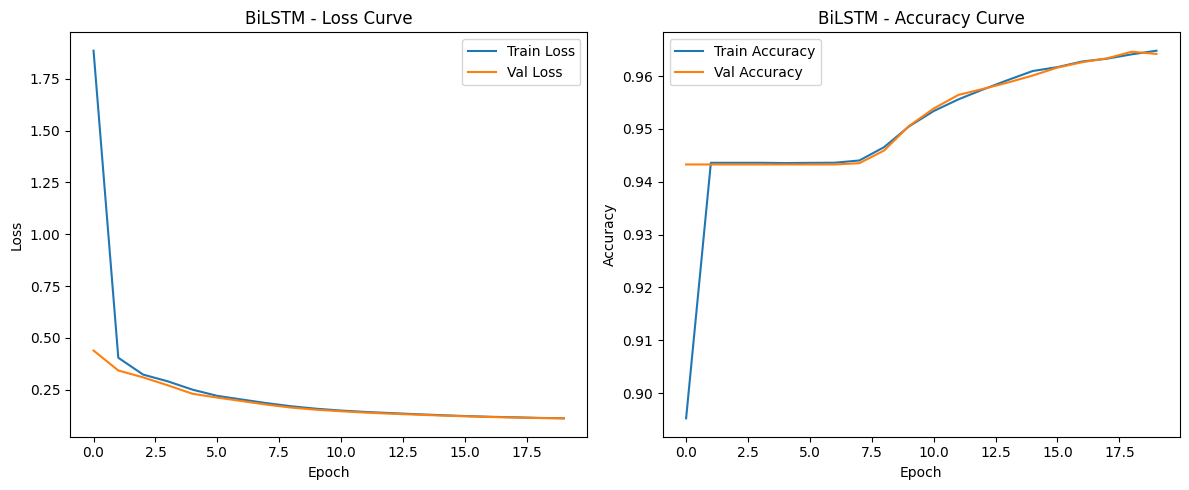

In [48]:
# Train and export BiLSTM model
import fasttext
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load FastText model
ft_model = fasttext.load_model("cc.id.300.bin")

# Build tag vocabulary
def build_tag_vocab(labels):
    tag_counts = Counter(tag for seq in labels for tag in seq)
    tag2idx = {tag: idx for idx, tag in enumerate(sorted(tag_counts.keys()))}
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    return tag2idx, idx2tag

tag2idx, idx2tag = build_tag_vocab(labels)

# Preprocess data with FastText embeddings
def preprocess_data(sentences, labels, tag2idx, max_len=128):
    X = [[ft_model.get_word_vector(word) for word in sent] for sent in sentences]
    X = tf.keras.preprocessing.sequence.pad_sequences(
        X, maxlen=max_len, padding='post', dtype='float32'
    )
    y = [[tag2idx.get(tag, tag2idx['O']) for tag in seq] for seq in labels]
    y = tf.keras.preprocessing.sequence.pad_sequences(
        y, maxlen=max_len, padding='post', value=tag2idx['O'], dtype='int32'
    )
    return X, y

# Prepare datasets
X_train, y_train = preprocess_data(train_sentences, train_labels, tag2idx)
X_valid, y_valid = preprocess_data(valid_sentences, valid_labels, tag2idx)

# Debug shapes
print("Shapes before training:", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

# Define BiLSTM model
def build_model(embedding_dim=300, max_len=128, num_tags=len(tag2idx)):
    input_layer = Input(shape=(max_len, embedding_dim))
    x = Dense(128, activation='relu')(input_layer)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    output_layer = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build and train model
model = build_model()
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_bilstm_model.h5', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('history_BiLSTM.csv', index=False)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BiLSTM - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('BiLSTM - Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

In [50]:
# Debug model predictions
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("best_bilstm_model.h5", compile=False)

# Preprocess text for prediction
def preprocess_text(text, max_len=128):
    words = text.split()
    x = [ft_model.get_word_vector(word) for word in words]
    x = tf.keras.preprocessing.sequence.pad_sequences(
        [x], maxlen=max_len, padding='post', dtype='float32'
    )[0]
    return tf.expand_dims(x, axis=0)

# Predict NER tags with debugging
def predict_ner(text):
    x = preprocess_text(text)
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=-1)[0]
    predicted_tags = [idx2tag.get(idx, 'UNKNOWN') for idx in y_pred[:len(text.split())]]
    print(f"Sentence: {text}")
    print(f"Raw predicted tags: {predicted_tags}")
    
    # Aggregate labels
    label_counts = {}
    for label in predicted_tags:
        if label != 'O' and '_' in label:
            category = label.split('_')[0]
            if category in ['FUEL', 'MACHINE', 'OTHERS', 'PART', 'PRICE', 'SERVICE']:
                label_counts[label] = label_counts.get(label, 0) + 1
    
    priority_categories = ['FUEL', 'MACHINE', 'OTHERS', 'PART', 'PRICE', 'SERVICE']
    for category in priority_categories:
        for polar in ['POSITIVE', 'NEGATIVE']:
            if f"{category}_{polar}" in label_counts:
                return {"label": f"{category}_{polar}", "sentence": text}
    
    return {"label": "No dominant label found", "sentence": text}

# Test sentences
test_sentences = [
    "Bensin hemat banget",
    "Mesin fortuner cepat panas",
    "Pelayanan yamaha kurang ramah",
    "Bensin bmw boros"
]

# Run predictions
print("Testing model predictions:")
for sentence in test_sentences:
    result = predict_ner(sentence)
    print(result)

Testing model predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sentence: Bensin hemat banget
Raw predicted tags: ['O', 'O', 'O']
{'label': 'No dominant label found', 'sentence': 'Bensin hemat banget'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Sentence: Mesin fortuner cepat panas
Raw predicted tags: ['O', 'O', 'O', 'O']
{'label': 'No dominant label found', 'sentence': 'Mesin fortuner cepat panas'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sentence: Pelayanan yamaha kurang ramah
Raw predicted tags: ['O', 'O', 'O', 'O']
{'label': 'No dominant label found', 'sentence': 'Pelayanan yamaha kurang ramah'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Sentence: Bensin bmw boros
Raw predicted tags: ['O', 'O', 'O']
{'label': 'No dominant label found', 'sentence': 'Bensin bmw boros'}
